# Unbinned Asimov Dataset

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import chi2, norm, ncx2, poisson
from scipy.optimize import minimize
from scipy import integrate

## EFT Toy problem

In [2]:
from matplotlib import rc

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'size': 22})
rc('text', usetex=True)

In [3]:
def sm(x):
    return 1 / 1.6261704595240913 * ((1 + x ** 2) * np.sqrt(x ** 2 - 1)) / x ** 4

def eft(x):
    return 1/ 35.66229480471837 * ((x ** 2 - 1) ** (3 / 2) ) / x

def f(x, c, sign=1):
    sigma = 1 + c * 0.1
    return sign / sigma * (sm(x) + c * 0.1 * eft(x))

def nu(c, lumi):
    sigma = 1 + c * 0.1
    return sigma * lumi

In [4]:
c_gen_sm = 0
c_gen_eft = 0.5
lumi = 1000

In [5]:
def sample_gen(c, n_dat):
    samples = []
    result = minimize(f, 1.5, args=(c, -1), options={'maxiter': 10000, 'ftol': 1e-7}, method='SLSQP', bounds=((1, 5),))
    f_max = -result.fun
    while len(samples) < n_dat:
        x = 1 + 4 * np.random.rand()
        y = np.random.rand()
        if y < f(x, c) / f_max:
            samples.append(x)
    return np.array(samples)

In [6]:
samples_eft = sample_gen(c_gen_eft, 1e6)
samples_sm = sample_gen(c_gen_sm, 1e6)

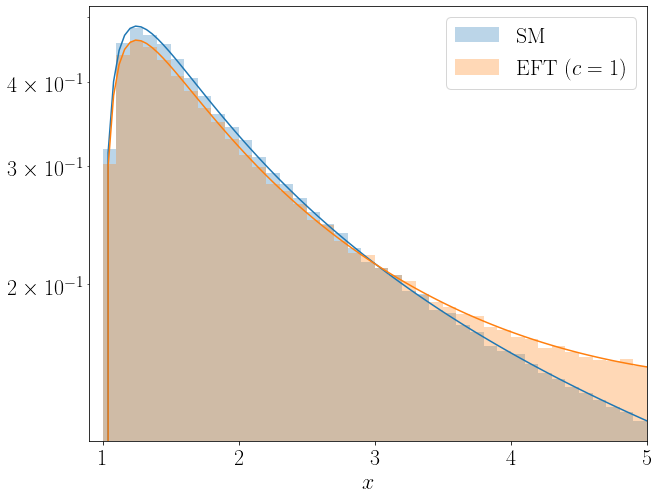

In [7]:
fig, ax = plt.subplots(figsize=(10,8))
ax.hist(samples_sm, bins=40, density = True, alpha=0.3, label=r'$\mathrm{SM}$')
ax.hist(samples_eft, bins=40, density = True, alpha=0.3, label=r'$\mathrm{EFT}\;(c=1)$')
x = np.linspace(1,5, 100)
ax.plot(x, f(x, c = 0), color='C0')
ax.plot(x, f(x, c = 0.5), color='C1')
plt.xlabel(r'$x$')
plt.yscale('log')
plt.xlim(0.9, 5)
plt.legend()
#plt.savefig('eft_toy_problem_dist.pdf')

In [8]:
def min_log_like_parent(c, data):
    
    log_like = np.sum(np.log(f(data, c, sign=1)))

    if np.isnan(log_like).any():
        return 1e6 # return a very large number when log likelihood is not defined
    else:
        return -log_like

def min_log_like_extended(c, data):
    
    nu_c = nu(c, lumi)
    log_like = -nu_c + np.sum(np.log(nu_c * f(data, c, sign=1)))

    if np.isnan(log_like).any():
        return 1e6 # return a very large number when log likelihood is not defined
    else:
        return -log_like

We take the maximum likelihood estimators of the parent dataset as the truth values

In [9]:
result_eft = minimize(min_log_like_parent, 0.9, args=(samples_eft,), options={'maxiter': 10000, 'ftol': 1e-9}, method='SLSQP', bounds=((-1, 3),))
c_truth_eft = result_eft.x[0]

result_sm = minimize(min_log_like_parent, 0.1, args=(samples_sm,), options={'maxiter': 10000, 'ftol': 1e-9}, method='SLSQP', bounds=((-1, 3),))
c_truth_sm = result_sm.x[0]

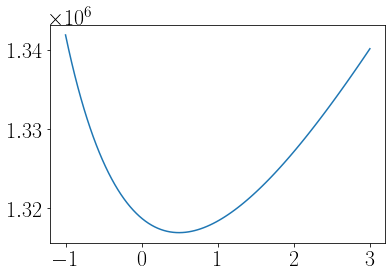

In [10]:
c_range = np.linspace(-1,3, 100)
plt.plot(c_range, [min_log_like_parent(c, samples_eft) for c in c_range])

In [11]:
c_truth_eft, c_truth_sm

(0.49167989575555515, -0.011151568099777017)

In [12]:
def plr_c(c, data, c_guess, c_min, c_max):
    
    p_c = - min_log_like_extended(c, data) 
    p_c_max = minimize(min_log_like_extended, 
                       c_guess, args=(data,), 
                       options={'maxiter': 10000, 'ftol': 1e-9}, 
                       method='SLSQP', 
                       bounds=((c_min, c_max),))
    c_mle = p_c_max.x[0]
    p_mle = - p_c_max.fun 

    q_c = - 2 * (p_c - p_mle)
    
    return q_c, c_mle

In [13]:
n_exp = 50000

In [14]:
nu_eft = nu(c_truth_eft, lumi)

# distribution of test statistic under the null (i.e. eft)

q_null_list = np.zeros(n_exp)
c_mle_null_list = np.zeros(n_exp)

for i in range(n_exp):
    
    n_dat = np.random.poisson(nu_eft)
    data = np.random.choice(samples_eft, n_dat) 
    q_c, c_mle = plr_c(c_truth_eft, data, c_guess=1.1, c_min=-1, c_max=3) # left bound should not result in negative pdf, ill defined log
    
    c_mle_null_list[i] = c_mle
    q_null_list[i] = q_c    

In [15]:
nu_sm = nu(c_truth_sm, lumi)

# distribution of test statistic under alternative hypothesis (i.e. sm)

q_alt_list = np.zeros(n_exp)
c_mle_alt_list = np.zeros(n_exp)

for i in range(n_exp):
    
    n_dat = np.random.poisson(nu_sm)
    data = np.random.choice(samples_sm, n_dat) 
    q_c, c_mle = plr_c(c_truth_eft, data, c_guess=0.1, c_min=-1.5, c_max=1.5)
    
    c_mle_alt_list[i] = c_mle
    q_alt_list[i] = q_c

Text(0.5, 0, '$\\hat{c}$')

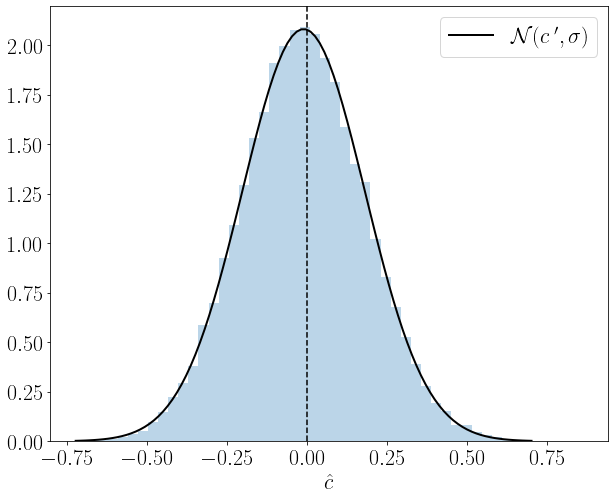

In [16]:
sigma = np.std(c_mle_alt_list)

fig, ax = plt.subplots(figsize=(10,8))
plt.hist(c_mle_alt_list, bins=50, alpha=0.3, density=True)
gauss = norm(loc=c_truth_sm, scale=sigma)
x = np.linspace(norm.ppf(0.0001, c_truth_sm, sigma), norm.ppf(0.9999, c_truth_sm, sigma), 100)
ax.plot(x, gauss.pdf(x), 'k-', lw=2, label='$\mathcal{N}(c\:\', \sigma)$')
ax.axvline(0, 0, 1, color='k', linestyle='dashed')
plt.legend()
plt.xlabel(r'$\hat{c}$')
#plt.savefig('dist_mle_c_sm.pdf')


In [17]:
nc_wald_mc = ((c_truth_eft - c_truth_sm) / np.std(c_mle_alt_list)) ** 2

In [18]:
nc_cont = lambda x: -2 * (nu(c_truth_sm, lumi) * f(x, c = c_truth_sm) * np.log((nu_eft * f(x, c = c_truth_eft)) / (nu(c_truth_sm, lumi) * f(x, c = c_truth_sm))) - nu(c_truth_eft, lumi) * f(x, c = c_truth_eft) + nu(c_truth_sm, lumi) * f(x, c = c_truth_sm))
nc_asi_unb, _  = integrate.quad(nc_cont, 1, 5)

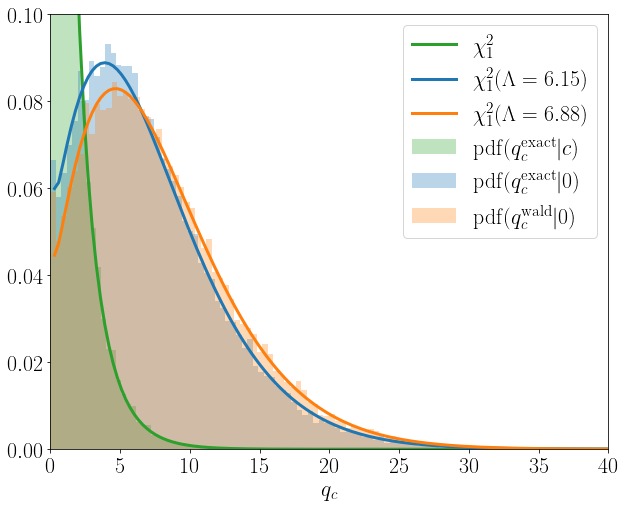

In [19]:
rv_nc_wald = ncx2(1, nc_wald_mc)
rv_nc_asi_unb = ncx2(1, nc_asi_unb)
rv = chi2(1)

x = np.linspace(0, 300, 1000)
fig, ax = plt.subplots(figsize=(10,8))


ax.hist(q_null_list, bins=50, density=True, alpha=0.3, label='$\mathrm{pdf}(q_c^{\mathrm{exact}}|c)$', color='C2')
ax.plot(x, rv.pdf(x), color='C2', linestyle='solid', lw=3, label=r'$\chi^2_1$')

ax.hist(q_alt_list, bins=100, density=True, alpha=0.3, label=r'$\mathrm{pdf}(q_c^{\mathrm{exact}}|0)$', color='C0')
ax.plot(x, rv_nc_asi_unb.pdf(x), color='C0', linestyle='solid', lw=3, label=r'$\chi^2_1(\Lambda={:.2f})$'.format(nc_asi_unb))

ax.hist(((np.mean(c_mle_null_list)-c_mle_alt_list)/np.std(c_mle_alt_list))**2, bins=100, density=True, alpha=0.3, label='$\mathrm{pdf}(q_c^{\mathrm{wald}}|0)$', color='C1')
ax.plot(x, rv_nc_wald.pdf(x), color='C1', linestyle='solid', lw=3, label=r'$\chi^2_1(\Lambda={:.2f})$'.format(nc_wald_mc))


plt.legend()
plt.ylim(0, 0.1)
plt.xlim(0, 40)
plt.xlabel(r'$q_c$')
plt.savefig('cont_asimov_comp_5e-1.pdf')